# Lale User Study - March 2021 - Lale treatment

Before we start, we load a dataset and print a few rows to see what it looks like.

In [4]:
#load forest covertype data, downsample for faster experiments
import pandas as pd
from lale.datasets import covtype_df
from sklearn.model_selection import train_test_split
from lale.lib.lale import categorical

# (train_X_all, train_y_all), (test_X, test_y) = covtype_df(test_size=5000)
# train_X, other_X, train_y, other_y = train_test_split(
#     train_X_all, train_y_all, train_size=10000, stratify=train_y_all
# )
# constant_columns = categorical(max_values=1)(train_X)
# train_X = train_X.drop(constant_columns, axis=1)
# test_X = test_X.drop(constant_columns, axis=1)
# pd.options.display.max_columns = None
# pd.concat([train_y, train_X], axis=1)

train_X = pd.read_pickle("train_x.pickle")
test_X = pd.read_pickle("test_x.pickle")
train_y = pd.read_pickle("train_y.pickle")
test_y = pd.read_pickle("test_y.pickle")

## Step 1. Understand a Pipeline

Consider the following Lale pipeline:

In [2]:
from lale.lib.sklearn import Normalizer
from lale.lib.sklearn import SelectKBest
from lale.lib.sklearn import KNeighborsClassifier
from lale.lib.lale import Project
from lale.lib.lale import categorical
from lale.lib.lale import ConcatFeatures

In [3]:
prepA = Project(drop_columns=categorical(max_values=2)) >> Normalizer()
prepB = Project(columns=categorical(max_values=2)) >> SelectKBest(k=8)
pipeline1 = (prepA & prepB) >> ConcatFeatures >> KNeighborsClassifier()

In [4]:
from sklearn.metrics import accuracy_score
trained1 = pipeline1.fit(train_X, train_y)
print(f"accuracy {accuracy_score(test_y, trained1.predict(test_X)):.1%}")

accuracy 68.7%


Please answer the following questions.

- Q1a: What is the final classifier in the pipeline?
- Q1b: Where does the input for the final classifier come from?
- Q1c: Which columns are subjected to feature selection?
- Q1d: Why do you think the pipeline contains feature selection there?

Handy documentation links:
[Lale API](https://lale.readthedocs.io/en/latest/),
[scikit-learn API](https://scikit-learn.org/stable/modules/classes.html).

In [5]:
# if you'd like to try things out, put your code here

### Answer for Step 1.

- Q1a: (your answer here)
- Q1b: (your answer here)
- Q1c: (your answer here)
- Q1d: (just say your answer, no need to write it down)

## 2. Refine without Search

Create a `pipeline2` that is similar to `pipeline1` from Question 1, except
that instead of Normalizer, it uses a StandardScaler, and
instead of KNeighborsClassifier, it uses a DecisionTreeClassifier with
a maximum depth of 3. Handy documentation links:
[Lale API](https://lale.readthedocs.io/en/latest/),
[scikit-learn API](https://scikit-learn.org/stable/modules/classes.html).

### Answer for Step 2.

In [6]:
# your code here

In [7]:
# reference answer (remove this cell for study participants)
from lale.lib.sklearn import StandardScaler
from lale.lib.sklearn import DecisionTreeClassifier
prepA2 = Project(drop_columns=categorical(max_values=2)) >> StandardScaler()
pipeline2 = (prepA2 & prepB) >> ConcatFeatures >> DecisionTreeClassifier(max_depth=3)
trained2 = pipeline2.fit(train_X, train_y)
print(f"accuracy {accuracy_score(test_y, trained2.predict(test_X)):.1%}")

accuracy 65.7%


### Questions about Step 2.

- Q2a. What documentation did you find the most helpful?
- Q2b. Did your new pipeline work the first time? If not, what went wrong?
- Q2c. What gotchas did you encounter, if any?

## Step 3. Refine with Search

Experiment with a search space of variants of `pipeline1` (from Question 1):

- normalizers: Normalizer, StandardScaler, or neither
- classifiers: LogisticRegression, ExtraTreesClassifier,
  KNeighborsClassifier, or DecisionTreeClassifier

Find the one with the best predictive performance.

### Answer for Step 3.

In [8]:
# your code here

In [9]:
# reference answer (remove this cell for study participants)
from lale.lib.lale import NoOp
from lale.lib.lale import Hyperopt
from lale.lib.sklearn import LogisticRegression
from lale.lib.sklearn import ExtraTreesClassifier

prepA3 = (
    Project(drop_columns=categorical(max_values=2))
    >> (Normalizer | StandardScaler | NoOp)
)
clf = (
    LogisticRegression
    | ExtraTreesClassifier
    | KNeighborsClassifier
    | DecisionTreeClassifier
)
pipeline3 = (prepA3 & prepB) >> ConcatFeatures >> clf

In [10]:
# reference answer (remove this cell for study participants)
trained3 = pipeline3.auto_configure(
    train_X, train_y, cv=3, optimizer=Hyperopt, max_evals=10
)

100%|███████| 10/10 [01:30<00:00,  9.05s/trial, best loss: -0.7181005743045811]


accuracy 72.9%


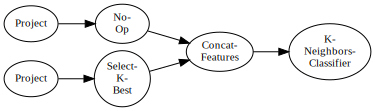

In [11]:
# reference answer (remove this cell for study participants)
print(f"accuracy {accuracy_score(test_y, trained3.predict(test_X)):.1%}")
trained3.visualize()

### Questions about Step 3.

- Q3a. Which pipeline variant lead to the highest accuracy?
- Q3b. What was the accuracy of that pipeline variant?
- Q3c. Did your new pipeline work the first time? If not, what went wrong?
- Q3d. What gotchas did you encounter, if any?
- Q3e. How do you normally search across pipeline variants?

## Step 4. Error Messages

Look at the error message from the following code:

In [12]:
from lale.lib.sklearn import LinearSVC
pipeline4 = SelectKBest(k=15) >> LinearSVC(penalty="l1", loss="hinge")
trained4 = pipeline4.fit(train_X, train_y)
pred_y = trained4.predict(test_X)

ValidationError: Invalid configuration for LinearSVC(penalty='l1', loss='hinge') due to constraint the combination of penalty=`l1` and loss=`hinge` is not supported.
Schema of constraint 1: {
    "description": "The combination of penalty=`l1` and loss=`hinge` is not supported",
    "anyOf": [
        {"type": "object", "properties": {"penalty": {"enum": ["l2"]}}},
        {
            "type": "object",
            "properties": {"loss": {"enum": ["squared_hinge"]}},
        },
    ],
}
Value: {'penalty': 'l1', 'loss': 'hinge', 'dual': True, 'tol': 0.0001, 'C': 1.0, 'multi_class': 'ovr', 'fit_intercept': True, 'intercept_scaling': 1.0, 'class_weight': None, 'verbose': 0, 'random_state': None, 'max_iter': 1000}

Make a small change to the pipeline to avoid that error.

Handy documentation links:
[sklearn docs for LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html),
[Lale docs for LinearSVC](https://lale.readthedocs.io/en/latest/modules/lale.lib.sklearn.linear_svc.html).

### Answer for Step 4.

In [ ]:
# your code here

In [13]:
# reference answer (remove this cell for study participants)
pipeline4 = SelectKBest(k=15) >> LinearSVC(penalty="l2", loss="hinge")
trained4 = pipeline4.fit(train_X, train_y)
pred_y = trained4.predict(test_X)

### Questions about Step 4.

- Q4a. What caused the error?
- Q4b. Which documentation did you find useful for diagnosing the error?
- Q4c. Was the schema in the error message useful?
- Q4d. How do you normally debug machine learning pipelines?